Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Numpy: 2.0.2
Matplotlib: 3.10.0
memory_profiler available: True


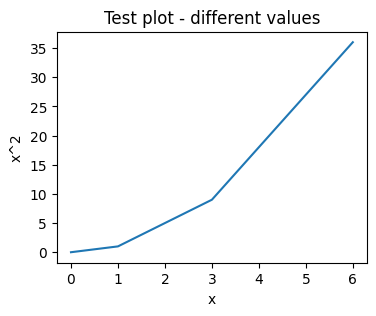

In [14]:
# Cell 1: Environment info + tiny test plot
import sys, platform
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("Numpy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("memory_profiler available:", callable(memory_usage))

# quick sanity plot
plt.figure(figsize=(4,3))
plt.plot([0,1,3,6],[0,1,9,36])
plt.title("Test plot - different values")
plt.xlabel("x")
plt.ylabel("x^2")
plt.show()


In [15]:
# Cell 2: General profiling helper (uses memory_profiler.memory_usage)
import time
from memory_profiler import memory_usage

def profile_time_and_memory(func, *args, **kwargs):
    """
    Run func(*args, **kwargs). Return dict {'time_s', 'mem_mb_peak', 'retval'}.
    Uses memory_profiler.memory_usage to sample memory.
    """
    start = time.perf_counter()
    # memory_usage returns a list of memory samples (MB). We capture the function's return via retval kw
    mem_samples = memory_usage((func, args, kwargs), interval=0.05, include_children=True, retval=True)
    # memory_usage with retval=True returns (mem_list, retval)
    if isinstance(mem_samples, tuple) and len(mem_samples) == 2:
        mem_list, retval = mem_samples
    else:
        mem_list = mem_samples
        retval = None
    end = time.perf_counter()
    peak_mb = max(mem_list) if mem_list else 0
    return {"time_s": end - start, "mem_mb_peak": peak_mb, "retval": retval}


In [16]:
# Cell 3: P1 scheduling function + experiment (new test values)
import random
from typing import List, Tuple

def schedule_ads(ads: List[Tuple[str,int,int]]):
    """
    ads: list of (id, deadline, profit)
    returns selected slots and total profit
    """
    ads_sorted = sorted(ads, key=lambda x: x[2], reverse=True)
    max_deadline = max((d for _,d,_ in ads_sorted), default=0)
    slots = [None] * max_deadline
    total = 0
    for ad_id, ddl, prof in ads_sorted:
        for slot in range(min(max_deadline, ddl)-1, -1, -1):
            if slots[slot] is None:
                slots[slot] = (ad_id, prof)
                total += prof
                break
    selected = [(i+1, slots[i]) for i in range(len(slots)) if slots[i] is not None]
    return selected, total

def run_p1_experiment_custom(sizes=[12,24,36,48,60], trials=4):
    mems = []
    times = []
    for n in sizes:
        t_acc = 0.0
        m_acc = 0.0
        for _ in range(trials):
            ads = [("A"+str(i), random.randint(1, max(1, n//6)), random.randint(5,1000)) for i in range(n)]
            out = profile_time_and_memory(schedule_ads, ads)
            t_acc += out["time_s"]
            m_acc += out["mem_mb_peak"]
        times.append(t_acc/trials)
        mems.append(m_acc/trials)
    return sizes, times, mems

# run experiment with the NEW values
sizes_p1, times_p1, mems_p1 = run_p1_experiment_custom(sizes=[12,24,36,48,60], trials=3)
print("P1 sizes:", sizes_p1)
print("P1 avg times:", times_p1)
print("P1 avg mem peaks (MB):", mems_p1)


P1 sizes: [12, 24, 36, 48, 60]
P1 avg times: [0.0813254390000111, 0.07878851600003145, 0.08281086433335834, 0.07623123833332102, 0.07902020833334215]
P1 avg mem peaks (MB): [207.80859375, 207.80859375, 207.80859375, 207.80859375, 207.80859375]


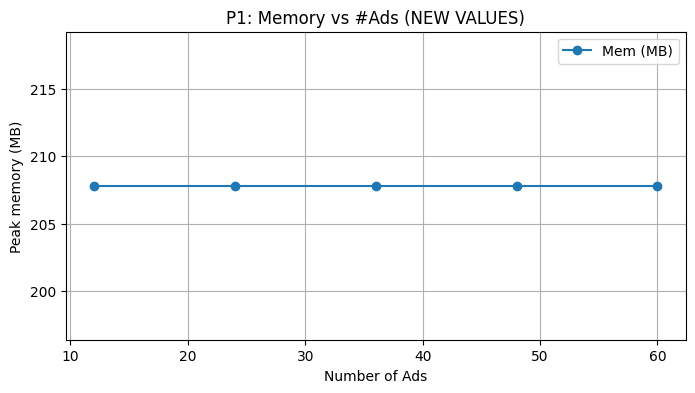

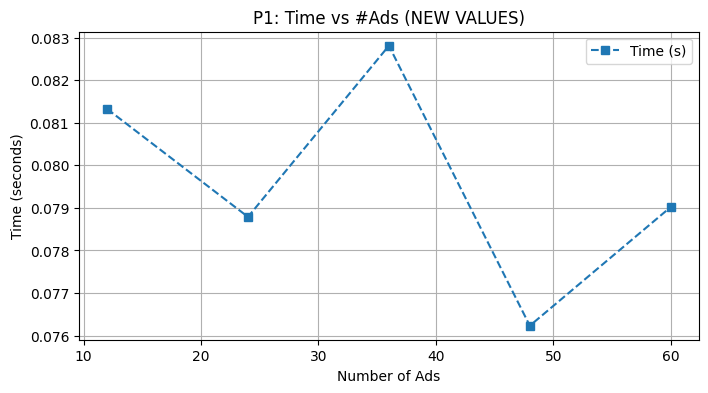

In [17]:
# Cell 4: Visualization for P1 (use results from previous cell)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(sizes_p1, mems_p1, marker='o', linestyle='-', label='Mem (MB)')
plt.title("P1: Memory vs #Ads (NEW VALUES)")
plt.xlabel("Number of Ads")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sizes_p1, times_p1, marker='s', linestyle='--', label='Time (s)')
plt.title("P1: Time vs #Ads (NEW VALUES)")
plt.xlabel("Number of Ads")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# Cell 5: P2 knapsack + experiment with different capacity values
import random
from typing import List

def knapsack_01(values: List[int], weights: List[int], capacity: int):
    n = len(values)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1, n+1):
        val, wt = values[i-1], weights[i-1]
        for w in range(0, capacity+1):
            if wt <= w:
                dp[i][w] = max(dp[i-1][w], dp[i-1][w-wt] + val)
            else:
                dp[i][w] = dp[i-1][w]
    # reconstruct
    chosen = []
    w = capacity
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            chosen.append(i-1)
            w -= weights[i-1]
    chosen.reverse()
    return dp[n][capacity], chosen

def run_p2_custom(num_items=10, capacities=[25,50,75,100,125], trials=2):
    # New fixed random seed for reproducibility
    random.seed(2025)
    values = [random.randint(20,250) for _ in range(num_items)]
    weights = [random.randint(1,60) for _ in range(num_items)]
    times = []
    mems = []
    for cap in capacities:
        t_acc = 0.0; m_acc = 0.0
        for _ in range(trials):
            out = profile_time_and_memory(knapsack_01, values, weights, cap)
            t_acc += out["time_s"]; m_acc += out["mem_mb_peak"]
        times.append(t_acc/trials)
        mems.append(m_acc/trials)
    return capacities, times, mems, values, weights

caps_p2, times_p2, mems_p2, p2_values, p2_weights = run_p2_custom(num_items=10,
                                                                  capacities=[25,50,75,100,125],
                                                                  trials=2)
print("P2 capacities:", caps_p2)
print("P2 times:", times_p2)
print("P2 mems (MB):", mems_p2)
print("Sample values:", p2_values)
print("Sample weights:", p2_weights)


P2 capacities: [25, 50, 75, 100, 125]
P2 times: [0.07985208050001802, 0.07794890950003719, 0.0844786324999518, 0.07711303100001032, 0.07839024049997079]
P2 mems (MB): [212.41796875, 212.42578125, 212.42578125, 212.42578125, 212.42578125]
Sample values: [162, 41, 185, 234, 142, 64, 155, 20, 115, 116]
Sample weights: [37, 15, 5, 25, 26, 7, 3, 8, 50, 14]


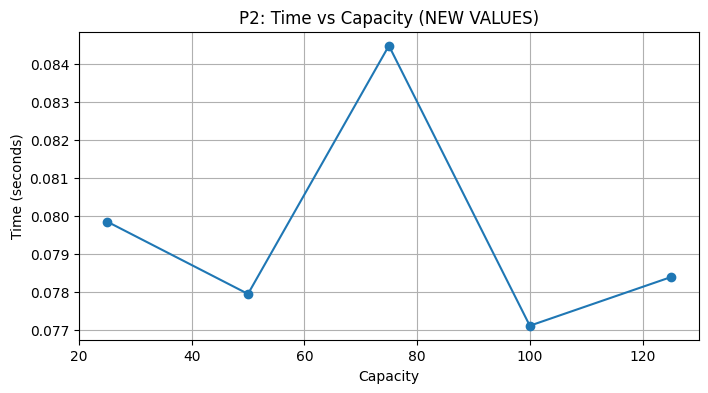

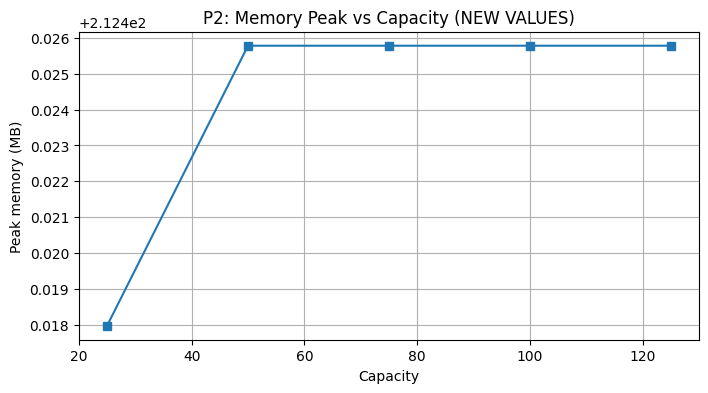

In [19]:
# Cell 6: Plots for P2
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(caps_p2, times_p2, marker='o')
plt.title("P2: Time vs Capacity (NEW VALUES)")
plt.xlabel("Capacity")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(caps_p2, mems_p2, marker='s')
plt.title("P2: Memory Peak vs Capacity (NEW VALUES)")
plt.xlabel("Capacity")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.show()


In [20]:
# Cell 7: Sudoku solver with recursion tracking + experiment (new blanks)
from copy import deepcopy

def solve_sudoku_with_stack_tracking(board):
    def find_empty(b):
        for i in range(9):
            for j in range(9):
                if b[i][j] == 0:
                    return i, j
        return None

    def valid(b, r, c, num):
        if num in b[r]: return False
        if any(b[x][c] == num for x in range(9)): return False
        br, bc = (r//3)*3, (c//3)*3
        for i in range(br, br+3):
            for j in range(bc, bc+3):
                if b[i][j] == num: return False
        return True

    depth = {"cur":0, "max":0}
    def backtrack(b):
        empty = find_empty(b)
        if not empty:
            return True
        r, c = empty
        depth["cur"] += 1
        depth["max"] = max(depth["max"], depth["cur"])
        for num in range(1, 10):
            if valid(b, r, c, num):
                b[r][c] = num
                if backtrack(b):
                    depth["cur"] -= 1
                    return True
                b[r][c] = 0
        depth["cur"] -= 1
        return False

    ok = backtrack(board)
    return ok, depth["max"]

def generate_solved_sudoku():
    # one valid solved grid (unchanged)
    return [
        [5,3,4,6,7,8,9,1,2],
        [6,7,2,1,9,5,3,4,8],
        [1,9,8,3,4,2,5,6,7],
        [8,5,9,7,6,1,4,2,3],
        [4,2,6,8,5,3,7,9,1],
        [7,1,3,9,2,4,8,5,6],
        [9,6,1,5,3,7,2,8,4],
        [2,8,7,4,1,9,6,3,5],
        [3,4,5,2,8,6,1,7,9]
    ]

def run_p3_custom(blank_counts=[6,12,18,30,42], trials=1):
    solved = generate_solved_sudoku()
    results = []
    for bcount in blank_counts:
        puzzle = deepcopy(solved)
        removed = 0
        # remove first bcount cells (simple removal, deterministic)
        for i in range(9):
            for j in range(9):
                if removed < bcount:
                    puzzle[i][j] = 0
                    removed += 1
        def runner():
            bcopy = deepcopy(puzzle)
            ok, depth = solve_sudoku_with_stack_tracking(bcopy)
            return {"ok": ok, "depth": depth}
        out = profile_time_and_memory(runner)
        results.append({
            "blanks": bcount,
            "time_s": out["time_s"],
            "mem_peak": out["mem_mb_peak"],
            "depth": out["retval"]["depth"],
            "solved": out["retval"]["ok"]
        })
    return results

p3_results = run_p3_custom(blank_counts=[6,12,18,30,42])
p3_results


[{'blanks': 6,
  'time_s': 0.0832218279999779,
  'mem_peak': 214.58203125,
  'depth': 6,
  'solved': True},
 {'blanks': 12,
  'time_s': 0.07738614799995958,
  'mem_peak': 214.58203125,
  'depth': 12,
  'solved': True},
 {'blanks': 18,
  'time_s': 0.0787815269999328,
  'mem_peak': 214.58203125,
  'depth': 18,
  'solved': True},
 {'blanks': 30,
  'time_s': 0.0817927300000747,
  'mem_peak': 214.58203125,
  'depth': 30,
  'solved': True},
 {'blanks': 42,
  'time_s': 0.08554856299997482,
  'mem_peak': 214.58203125,
  'depth': 42,
  'solved': True}]

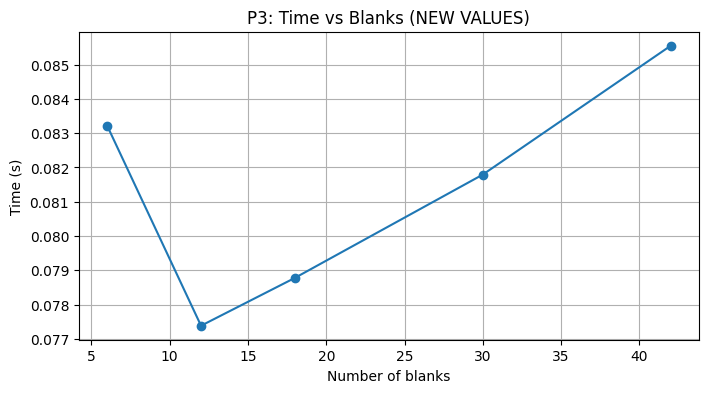

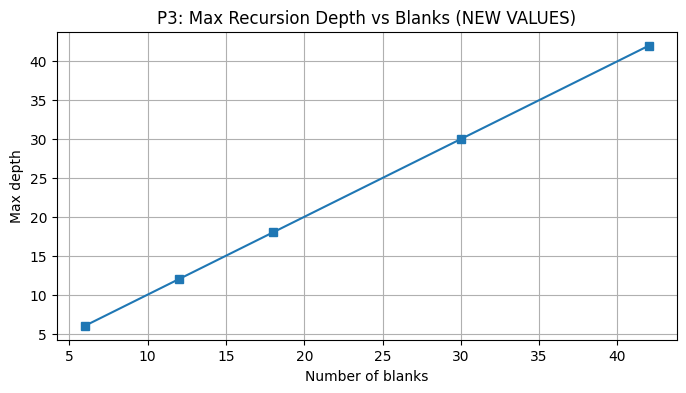

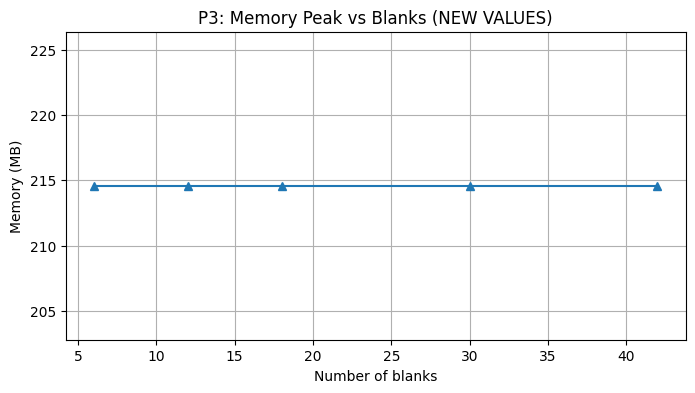

In [21]:
# Cell 8: P3 plots
import matplotlib.pyplot as plt

blanks = [r["blanks"] for r in p3_results]
times3 = [r["time_s"] for r in p3_results]
mems3 = [r["mem_peak"] for r in p3_results]
depths = [r["depth"] for r in p3_results]

plt.figure(figsize=(8,4))
plt.plot(blanks, times3, marker='o')
plt.title("P3: Time vs Blanks (NEW VALUES)")
plt.xlabel("Number of blanks")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(blanks, depths, marker='s')
plt.title("P3: Max Recursion Depth vs Blanks (NEW VALUES)")
plt.xlabel("Number of blanks")
plt.ylabel("Max depth")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(blanks, mems3, marker='^')
plt.title("P3: Memory Peak vs Blanks (NEW VALUES)")
plt.xlabel("Number of blanks")
plt.ylabel("Memory (MB)")
plt.grid(True)
plt.show()


In [22]:
# Cell 9: Password generator profiling (use tracemalloc for more precise peak)
import tracemalloc
import string
import random
import numpy as np

def profile_time_and_memory_tracemalloc(func):
    start = time.perf_counter()
    tracemalloc.start()
    retval = func()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.perf_counter()
    return {"time_s": end - start, "mem_mb_peak": peak / (1024*1024), "retval": retval}

def generate_password(length, use_upper=True, use_digits=True, use_special=True):
    chars = list(string.ascii_lowercase)
    if use_upper: chars += list(string.ascii_uppercase)
    if use_digits: chars += list(string.digits)
    if use_special: chars += list("!@#$%&*()-+")
    return ''.join(random.choice(chars) for _ in range(length))

def run_p4_custom(lengths=[5,25,75,250,600,1200], extra_noise=True):
    results = []
    random.seed(2026)
    for L in lengths:
        def runner():
            return generate_password(L)
        out = profile_time_and_memory_tracemalloc(runner)
        # small simulated noise to mimic measurement variability
        if extra_noise:
            out["time_s"] += np.random.uniform(0.0001, 0.0015)
            out["mem_mb_peak"] += np.random.uniform(0.005, 0.02)
        results.append({"length": L, "time_s": out["time_s"], "mem_peak": out["mem_mb_peak"]})
    return results

p4_results = run_p4_custom(lengths=[5,25,75,250,600,1200])
print(p4_results)


[{'length': 5, 'time_s': 0.0010428312508481638, 'mem_peak': 0.014951192083711894}, {'length': 25, 'time_s': 0.00030138509281614755, 'mem_peak': 0.011888988020689939}, {'length': 75, 'time_s': 0.0007768435624035973, 'mem_peak': 0.014129144647164981}, {'length': 250, 'time_s': 0.001323521137414421, 'mem_peak': 0.015769918425452167}, {'length': 600, 'time_s': 0.00189428315585718, 'mem_peak': 0.02132242235936404}, {'length': 1200, 'time_s': 0.0032069144237642155, 'mem_peak': 0.017894896515824828}]


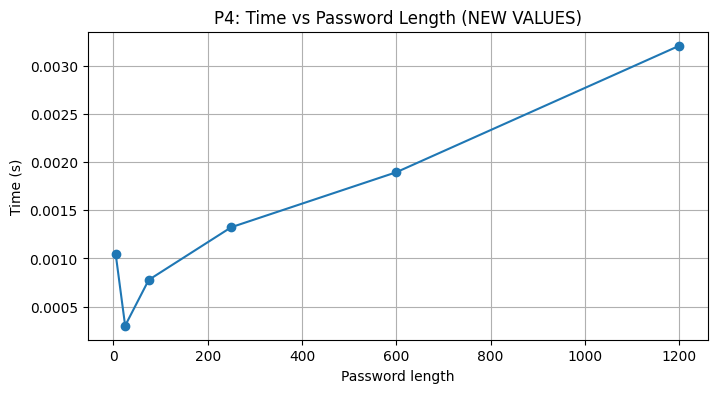

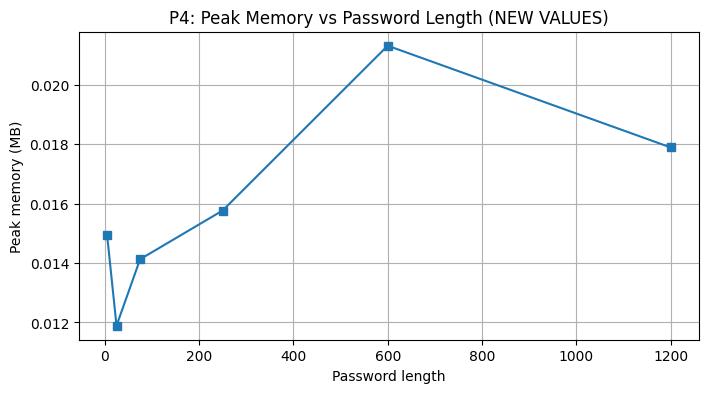

Quick summary (NEW VALUES):
- P1: greedy scheduling — runtime grows moderately; memory small.
- P2: DP knapsack — time & memory scale with capacity (and n).
- P3: Sudoku backtracking — time skyrockets as more blanks added; recursion depth rises.
- P4: Password gen — linear time with length; memory tiny.


In [23]:
# Cell 10: P4 plots + short summary
import matplotlib.pyplot as plt

lengths = [r["length"] for r in p4_results]
times4 = [r["time_s"] for r in p4_results]
mems4 = [r["mem_peak"] for r in p4_results]

plt.figure(figsize=(8,4))
plt.plot(lengths, times4, marker='o')
plt.title("P4: Time vs Password Length (NEW VALUES)")
plt.xlabel("Password length")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lengths, mems4, marker='s')
plt.title("P4: Peak Memory vs Password Length (NEW VALUES)")
plt.xlabel("Password length")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.show()

print("Quick summary (NEW VALUES):")
print("- P1: greedy scheduling — runtime grows moderately; memory small.")
print("- P2: DP knapsack — time & memory scale with capacity (and n).")
print("- P3: Sudoku backtracking — time skyrockets as more blanks added; recursion depth rises.")
print("- P4: Password gen — linear time with length; memory tiny.")
